In [ ]:
from scipy.stats import nbinom
import matplotlib.pyplot as plt
import numpy as np
import random

import anndata as ad
import pandas as pd
from scipy.sparse import coo_matrix, csc_matrix

In [2]:
# Container for simulated data
num_samples = 3


# how many samples to generate
patients_to_generate = 200
genes_to_generate = 200

theta_value = 1

# probability of samples/genes to be sorted
sample_sort_prob = 0.05
gene_sort_prob = 0.05

# balance between batches
# do not set to 0 or 1 (will have to fix this)
batch_balance = 0.5

# other parameters
# whether or not to draw distributions when generating simulated genes
# note that there's no limitations to this; if you're creating 10000 genes it'll draw 10000 plots
draw_NB_data = False

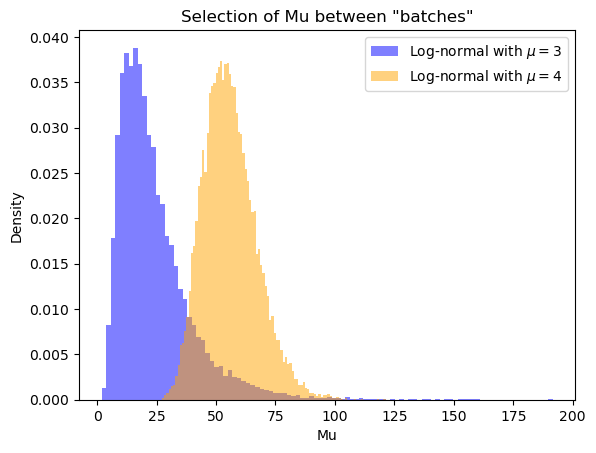

In [3]:
# In this version of the code, I want to create a distribution to "pull" our NB Mu parameters from
# we discussed log-normal
mu_pull_dist_1 = 3
mu_pull_dist_2 = 4


sigma1 = 0.6  # standard deviation of the logarithm of the variable (example value)
sigma2 = 0.2  # standard deviation of the logarithm of the variable (example value)

# Generate a sample from the log-normal distribution
# Generate samples for both distributions
sample_size = patients_to_generate*100 # multiplication ensures a varied number of possible values
samples1 = np.random.lognormal(mean=mu_pull_dist_1, sigma=sigma1, size=sample_size)
samples2 = np.random.lognormal(mean=mu_pull_dist_2, sigma=sigma2, size=sample_size)

samples1_rounded = np.round(samples1, 6)
samples2_rounded = np.round(samples2, 6)

# Plotting the samples
plt.hist(samples1_rounded, bins=100, density=True, alpha=0.5, color='blue', label=f'Log-normal with $\mu={mu_pull_dist_1}$')
plt.hist(samples2_rounded, bins=100, density=True, alpha=0.5, color='orange', label=f'Log-normal with $\mu={mu_pull_dist_2}$')
plt.title('Selection of Mu between "batches"')
plt.xlabel('Mu')
plt.ylabel('Density')
# plt.xscale('log')
plt.legend()
plt.show()

In [4]:
# for now, theta will be simple, both batch 1 and batch 2 will have the same parameters
# will likely make this more complex in the future
theta_pull_dist_1 = theta_pull_dist_2 = theta_value # will try 1, 2, etc


In [5]:

# Using a list comprehension to create the list
train_data = [[] for _ in range(num_samples)]
valid_data = [[] for _ in range(num_samples)]

gene_names = []
gene_mu1, gene_var1, gene_mu2, gene_var2 = [], [], [], []

# we have to sample from both log normals outside of the loop so that we can ensure replacement
sampled_mus_batch1 = np.random.choice(samples1_rounded, size=genes_to_generate, replace=False)
sampled_mus_batch2 = np.random.choice(samples2_rounded, size=genes_to_generate, replace=False)

# Bernouli trial idea didn't work out
# This way, all samples will get the same mu, not a partial amount
samples_indices = [[] for _ in range(num_samples)]
for tau in range(num_samples):
    samples_indices[tau] = np.random.binomial(n=1, p=batch_balance, size=patients_to_generate)

# In 4.2, I'd also like to randomly choose which genes to sort (these ensure that edges will be created)
genes_to_sort = np.random.binomial(n=1, p=gene_sort_prob, size=genes_to_generate)


for i in range(genes_to_generate):
    # so we compute the p and n parameters for each batch using their respective Mu/thetas
    mu_batch1 = sampled_mus_batch1[i]
    var_batch1 = mu_batch1 + (mu_batch1**2 / theta_pull_dist_1)
    n_batch1 = mu_batch1**2 / (var_batch1 - mu_batch1)
    p_batch1 = n_batch1 / (n_batch1 + mu_batch1)

    mu_batch2 = sampled_mus_batch2[i]
    var_batch2 = mu_batch2 + (mu_batch2**2 / theta_pull_dist_2)
    n_batch2 = mu_batch2**2 / (var_batch2 - mu_batch2)
    p_batch2 = n_batch2 / (n_batch2 + mu_batch2)

    for tau in range(num_samples):

        # we then sample M (patients) values from both NBs
        counts_batch1 = nbinom.rvs(n_batch1, p_batch1, size=patients_to_generate)
        counts_batch2 = nbinom.rvs(n_batch2, p_batch2, size=patients_to_generate)

        # sorting genes will ensure genes/samples will correlate with each other
        if(genes_to_sort[i] == 1):
            counts_batch1 = np.sort(counts_batch1)
            counts_batch2 = np.sort(counts_batch2)

        # and we use the Bernouli to select from which NB distribution do we take values from
        selected_data_train = np.where(samples_indices[tau] == 0, counts_batch1, counts_batch2)
        
        # append it to a list of gene expression values
        train_data[tau].append(selected_data_train)  

        # repeat for validation
        counts_batch3 = nbinom.rvs(n_batch1, p_batch1, size=patients_to_generate)
        counts_batch4 = nbinom.rvs(n_batch2, p_batch2, size=patients_to_generate)

        if(genes_to_sort[i] == 1):
            counts_batch3 = np.sort(counts_batch3)
            counts_batch4 = np.sort(counts_batch4)

        # and we use the Bernouli to select from which NB distribution do we take values from
        selected_data_val = np.where(samples_indices[tau] == 0, counts_batch3, counts_batch4)

        # append it to a list of gene expression values
        valid_data[tau].append(selected_data_val)  

   
    # Saving Mus/Thetas; to be placed in the AnnData 'var' table
    gene_mu1.append(mu_batch1)
    gene_var1.append(theta_pull_dist_1)
    gene_mu2.append(mu_batch2)
    gene_var2.append(theta_pull_dist_2)

    # Creating a unique gene name
    gene_name = "Gene_" + str(i + 1)
    gene_names.append(gene_name)

    # draw expression selected out if desired
    title = "Expression for Gene " + str(i + 1)

    if (draw_NB_data is True):
        plt.hist(selected_data_train, bins=50, color="blue")
        plt.xlabel("Expression")
        plt.ylabel("Frequency")
        plt.title(title)
        plt.show()

        


In [6]:
# So now we have to save these results as an AnnData table with batch in the obs
counts_for_anndata_train = [[] for _ in range(num_samples)]
counts_for_anndata_valid = [[] for _ in range(num_samples)]

# sort samples outside of loop to ensure similar sorting patterns between tissues
split_sort = sample_sort_prob / 2
samples_to_sort = np.random.binomial(n=1, p=split_sort, size=patients_to_generate)
samples_to_reverse_sort = np.random.binomial(n=1, p=split_sort, size=patients_to_generate)
intersected = np.intersect1d(samples_to_sort, samples_to_reverse_sort)
common_indices = [i for i in range(len(genes_to_sort)) if genes_to_sort[i] == 1 and samples_to_reverse_sort[i] == 1]

for tau in range(num_samples):
# append genes into a single matrix, and transpose so rows are samples and not rows
    counts_for_anndata_train[tau] = np.transpose(np.array(train_data[tau]))
    counts_for_anndata_valid[tau] = np.transpose(np.array(valid_data[tau]))

    # if both Bernouli distributions select the same position, set it to the first sort
    for index in common_indices:
        samples_to_reverse_sort[index] = 0

    for samp in range(len(samples_to_sort)):
        if samples_to_sort[samp] == 1:
            counts_for_anndata_train[tau][samp] = np.sort(counts_for_anndata_train[tau][samp])
            counts_for_anndata_valid[tau][samp] = np.sort(counts_for_anndata_valid[tau][samp])

    for samp in range(len(samples_to_reverse_sort)):
        if samples_to_reverse_sort[samp] == 1:
            counts_for_anndata_train[tau][samp] = np.sort(counts_for_anndata_train[tau][samp])
            counts_for_anndata_valid[tau][samp] = np.sort(counts_for_anndata_valid[tau][samp])



In [ ]:
### Prep AnnData, Obs and Var across all samples
adata_train = [[] for _ in range(num_samples)]
adata_valid = [[] for _ in range(num_samples)]

for tau in range(num_samples):
    adata_train[tau] = ad.AnnData(X=counts_for_anndata_train[tau], var=pd.DataFrame(index=gene_names), dtype=np.int64)
    adata_train[tau].obs['batch'] = samples_indices[tau]
    new_names = ["tau" + str(tau + 1) + "_" + str(i) for i in range(adata_train[tau].n_obs)]  # Creating new names
    adata_train[tau].obs_names = new_names

    adata_valid[tau] = ad.AnnData(X=counts_for_anndata_valid[tau], var=pd.DataFrame(index=gene_names), dtype=np.int64)
    adata_valid[tau].obs['batch'] = samples_indices[tau]
    new_names = ["tau" + str(tau + 1) + "_" + str(i) for i in range(adata_valid[tau].n_obs)]  # Creating new names
    adata_valid[tau].obs_names = new_names

    # fill in var table
    adata_train[tau].var['gene'], adata_valid[tau].var['gene'] = gene_names, gene_names
    adata_train[tau].var['mu_batch1'], adata_valid[tau].var['mu_batch1'] = gene_mu1, gene_mu1
    adata_train[tau].var['theta_batch1'], adata_valid[tau].var['theta_batch1'] = gene_var1, gene_var1
    adata_train[tau].var['mu_batch2'], adata_valid[tau].var['mu_batch2'] = gene_mu2, gene_mu2
    adata_train[tau].var['theta_batch2'], adata_valid[tau].var['theta_batch2'] = gene_var2, gene_var2


In [8]:
### RELEATE TAUS HERE - currently simplified (no order mixing)
column_labels = [f'tau_{i + 1}' for i in range(num_samples)]  # Customize labels as needed
obs_table = pd.DataFrame(columns=column_labels)

# Populate the DataFrame with obs_names from each AnnData object
for i, ad in enumerate(adata_train):
    # Ensure that the length of obs_names matches the longest obs_names list among the AnnData objects
    current_obs_names = ad.obs_names
    obs_table[f'tau_{i + 1}'] = pd.Series(current_obs_names)

# Handle different lengths of obs_names by filling missing values
obs_table = obs_table.apply(lambda col: col.dropna().reset_index(drop=True))


# Set obs_table names
full_obs_table = [[] for _ in range(num_samples)]
for tau in range(num_samples):
    obs_table.index = obs_table.iloc[:, tau]  # `iloc[:, 0]` accesses the first column
    full_obs_table[tau] = obs_table.copy()
    full_obs_table[tau].index.name = None
    


In [ ]:
# Generate Sample-Sample matrix and save AnnData

for tau in range(num_samples):
    adata_train[tau].obsm['sample_association'] = full_obs_table[tau]

    # sample/sample
    df_transposed = pd.DataFrame(adata_train[tau].X.T, columns=adata_train[tau].obs_names, index=adata_train[tau].var_names)

    correlation_matrix_samples = df_transposed.corr()
    sample_sample_adj = (correlation_matrix_samples.abs() > 0.7).astype(int)
    np.fill_diagonal(sample_sample_adj.values, 1)

    # Count the number of 1s in the adjacency matrix
    num_ones_samples = np.sum(sample_sample_adj.values)

    # and the adjacency tables need to be 'coo'
    sample_sample_adj_coo = csc_matrix(sample_sample_adj)
    adata_train[tau].obsm['sample_sample_adj'] = sample_sample_adj_coo

    # and lets save the data
    folder_path = '/path/to/output/'

    file_path = folder_path + 'sim_full.M_' + str(patients_to_generate) + '_N_' + str(genes_to_generate) + '_th_' + str(theta_pull_dist_1) + '_batch_bal_' + str(batch_balance) + '.Msort_' + str(sample_sort_prob) + '_Nsort_' + str(gene_sort_prob) + '.train.tau_' + str(tau+1) + '.h5ad'

    # Save the AnnData object
    adata_train[tau].write(file_path)


In [ ]:
## VALIDATION
for tau in range(num_samples):
    adata_valid[tau].obsm['sample_association'] = full_obs_table[tau]

    # sample/sample
    df_transposed = pd.DataFrame(adata_valid[tau].X.T, columns=adata_valid[tau].obs_names, index=adata_valid[tau].var_names)

    correlation_matrix_samples = df_transposed.corr()
    sample_sample_adj = (correlation_matrix_samples.abs() > 0.7).astype(int)
    np.fill_diagonal(sample_sample_adj.values, 1)

    # Count the number of 1s in the adjacency matrix
    num_ones_samples = np.sum(sample_sample_adj.values)

    # and the adjacency tables need to be 'coo'
    sample_sample_adj_coo = csc_matrix(sample_sample_adj)
    adata_valid[tau].obsm['sample_sample_adj'] = sample_sample_adj_coo
    
    file_path = folder_path + 'sim_full.M_' + str(patients_to_generate) + '_N_' + str(genes_to_generate) + '_th_' + str(theta_pull_dist_1) + '_batch_bal_' + str(batch_balance) + '.Msort_' + str(sample_sort_prob) + '_Nsort_' + str(gene_sort_prob) + '.validation.tau_' + str(tau+1) + '.h5ad'

    # Save the AnnData object
    adata_valid[tau].write(file_path)



In [11]:
# checking to see how many sample-sample "edges" were created in this run
print("# Sample Edges", np.sum(np.sum(sample_sample_adj)))
#print("# Gene Edges", np.sum(np.sum(gene_gene_adj)))
print(adata_train[0].obsm['sample_association'])

print(adata_train[1].obsm["sample_sample_adj"])

# Sample Edges 242
             tau_1     tau_2     tau_3
tau1_0      tau1_0    tau2_0    tau3_0
tau1_1      tau1_1    tau2_1    tau3_1
tau1_2      tau1_2    tau2_2    tau3_2
tau1_3      tau1_3    tau2_3    tau3_3
tau1_4      tau1_4    tau2_4    tau3_4
...            ...       ...       ...
tau1_195  tau1_195  tau2_195  tau3_195
tau1_196  tau1_196  tau2_196  tau3_196
tau1_197  tau1_197  tau2_197  tau3_197
tau1_198  tau1_198  tau2_198  tau3_198
tau1_199  tau1_199  tau2_199  tau3_199

[200 rows x 3 columns]
  (0, 0)	1
  (1, 1)	1
  (2, 2)	1
  (3, 3)	1
  (4, 4)	1
  (5, 5)	1
  (6, 6)	1
  (7, 7)	1
  (8, 8)	1
  (9, 9)	1
  (10, 10)	1
  (11, 11)	1
  (12, 12)	1
  (13, 13)	1
  (14, 14)	1
  (75, 14)	1
  (105, 14)	1
  (113, 14)	1
  (145, 14)	1
  (149, 14)	1
  (187, 14)	1
  (15, 15)	1
  (16, 16)	1
  (17, 17)	1
  (18, 18)	1
  :	:
  (181, 181)	1
  (182, 182)	1
  (183, 183)	1
  (184, 184)	1
  (185, 185)	1
  (186, 186)	1
  (14, 187)	1
  (75, 187)	1
  (105, 187)	1
  (113, 187)	1
  (145, 187)	1
  (149, 18

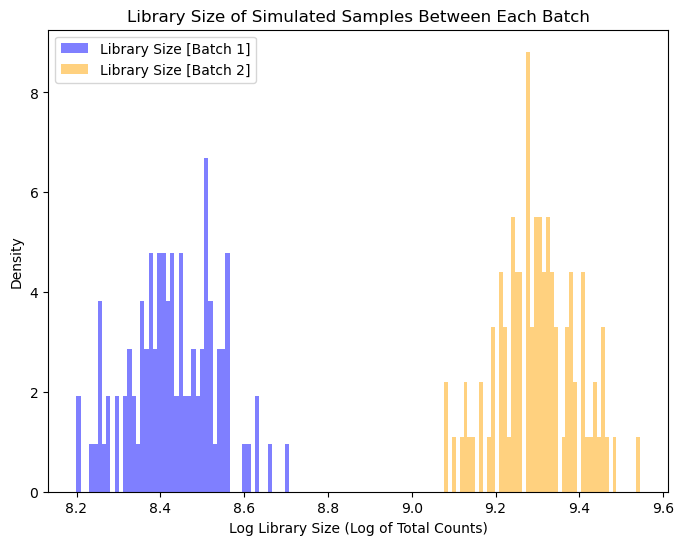

In [12]:
# draw library size information distrubtions
library_sizes = np.log(adata_train[0].X.sum(axis=1))

batches = adata_train[0].obs['batch']
library_sizes_batch1 = library_sizes[batches == 0]
library_sizes_batch2 = library_sizes[batches == 1]

# Plotting the samples
#plt.hist(library_sizes, bins=50, density=True, alpha=0.5, color='blue', label=f'Library Size [all samples]')
plt.figure(figsize=(8, 6))
plt.hist(library_sizes_batch1, bins=50, density=True, alpha=0.5, color='blue', label='Library Size [Batch 1]')
plt.hist(library_sizes_batch2, bins=50, density=True, alpha=0.5, color='orange', label='Library Size [Batch 2]')
plt.title('Library Size of Simulated Samples Between Each Batch')
plt.xlabel('Log Library Size (Log of Total Counts)')
plt.ylabel('Density')
# plt.yscale('log')  # Use a log scale for the y-axis
#plt.xscale('log')
plt.legend()
plt.show()

# you can clearly see the difference caused by the two Mus